Project patch-wise features to 2D uMAP space

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import r_utils
from models import PredictionModel
from dataset import (
    CranberryPatchDataset, 
    DefaultSplitDescriptor, CoordSplitDescriptor, GenotypeSplitDescriptor,
)

from typing import Optional, Callable
import umap
import torch
import torch.functional as F
from transformers import AutoImageProcessor
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM
# import requests
# from PIL import Image

Load model and image processor:

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PredictionModel(
    # backbone_name='facebook/dinov2-with-registers-base',
    # backbone_name='google/siglip2-base-patch16-224',
    backbone_name ='google/vit-base-patch16-224',
    prediction_heads = [],
    lora_options=None,
    do_normalization=False
).to(device)


# checkpoint_name = './checkpoints_pw/facebook_dinov2-with-registers-base_time_8_epochs_pw_14h57m.pth'
checkpoint_name = './checkpoints_pw/google_vit-base-patch16-224_time_8_epochs_pw_15h59m.pth'

model.load(checkpoint_name)

processor = AutoImageProcessor.from_pretrained(
    model.backbone_name,
    do_rescale=False,
    do_resize=False,
    use_fast=False
)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Loading from ./checkpoints_pw/google_vit-base-patch16-224_time_8_epochs_pw_15h59m.pth


Prepare the dataset identically to how it was done when training the loaded checkpoint:

In [34]:
bog_2_patch_df = torch.load('prepped_data/bog_2_patches_p224_size_1344x2016.pt', weights_only=False) # 'p224' indicates that the patches are 224x224 pixels
dataset_locations = r_utils.load_toml('./dataset_locations.toml')
dataset = CranberryPatchDataset(bog_2_patch_df, dataset_locations)

# use the dataset split descriptor that was stored in the model checkpoint
data_splits = model.dataset_split_descriptor.split(dataset)
val_dataset = data_splits['test_dataset']
val_idxs = data_splits['test_idxs']

gen1 = torch.Generator().manual_seed(1)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, generator=gen1)

print(model.dataset_split_descriptor)

Splitting dataset by patch coordinates
Attempting to split the dataset with a 0.8/0.2 split. Actual split: 0.8/0.2.
CoordSplitDescriptor(approx_train_size=0.8)


Get the embedding:

In [35]:
@torch.no_grad()
def run_inference(model, processor, dataloader):
    model.eval()
    device = next(model.parameters()).device
    all_outputs = []

    print(f"Running inference on {device}")
    for patch, _ in tqdm(dataloader):
        if processor is not None:
            inputs = processor(patch, return_tensors='pt').to(device)
        else:
            inputs = {'pixel_values': patch.to(device)}
            
        outputs = model(inputs)['latent']
        all_outputs.append(outputs.cpu())

    return torch.cat(all_outputs, dim=0)

features = run_inference(model, processor, val_dataloader)

Running inference on cuda:0


100%|██████████| 187/187 [00:16<00:00, 11.14it/s]


In [36]:
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(features)

Plot the data

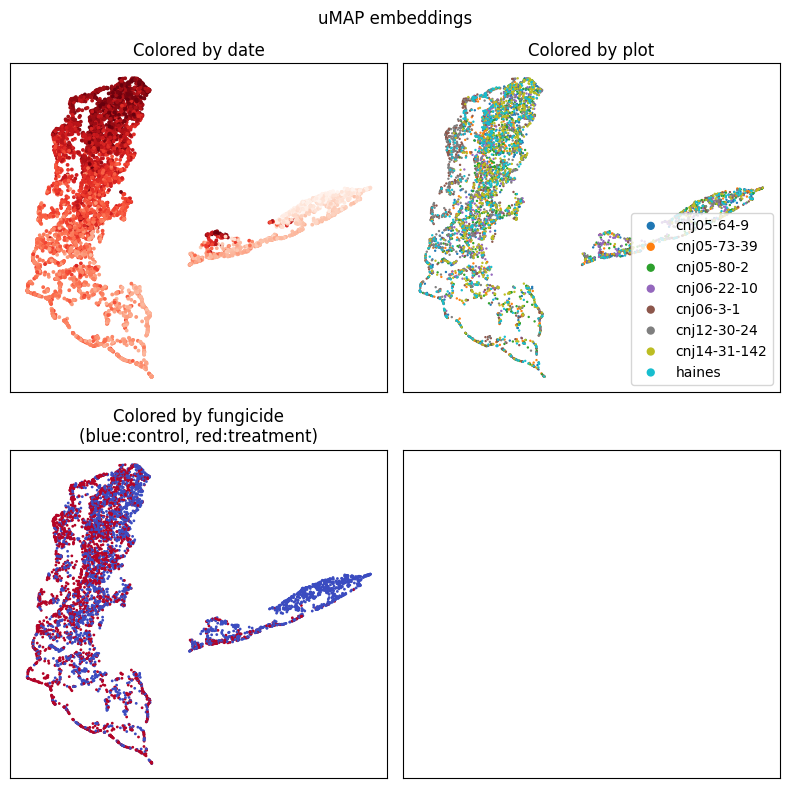

In [37]:
relevant_rows = bog_2_patch_df.iloc[val_idxs]

date_codes = relevant_rows['date'].astype('category').cat.codes
plot_codes = relevant_rows['plot'].astype('category').cat.codes
plot_labels = list(relevant_rows['plot'])
fungicide_codes = relevant_rows['fungicide'].astype('category').cat.codes

date_c, _ = r_utils.values_to_colors(list(date_codes), cmap_name='Reds')
plot_c, _ = r_utils.values_to_colors(list(plot_codes), cmap_name='tab10')
fungicide_c, fclist = r_utils.values_to_colors(list(fungicide_codes), cmap_name='coolwarm')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axs = axs.flatten()
axs[0].scatter(*embedding.T, s=3, c=date_c)
axs[0].set_title("Colored by date")


axs[1].set_title("Colored by plot")
for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    axs[1].scatter(
        embedding[i, 0], embedding[i, 1], label=label, s=0.5, c=np.array(plot_c)[i]
    )
l1 = axs[1].legend(markerscale=7)

axs[2].scatter(*embedding.T, s=1, c=fungicide_c)
axs[2].set_title("Colored by fungicide\n(blue:control, red:treatment)")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("uMAP embeddings")
plt.tight_layout()
plt.show()

Visualizations with images

**Note:** you may have to run this cell or the following cell twice to get the correct plot to show up

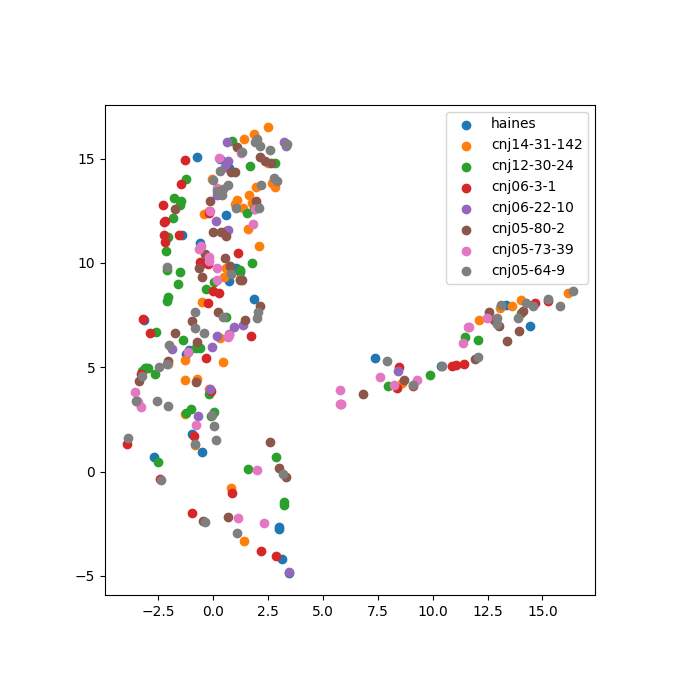

'selected image 43'

In [ ]:
%matplotlib widget
import plotting_vis
from importlib import reload
reload(plotting_vis)

# take only a smaller subset of points to plot
k = 300
np.random.seed(3)
indices = np.random.choice(embedding.shape[0], size=k, replace=False, )

features_subset = np.array(embedding[indices])
rich_labels = relevant_rows[['plot', 'date', 'patch_coords', 'fungicide']].iloc[indices].to_dict(orient='list')

p_dev = torch.tensor(processor.image_std).view(3,1,1)
p_mean = torch.tensor(processor.image_mean).view(3,1,1)
images = [val_dataset[i][0] for i in indices]

plotting_vis.plot_with_annotations(features_subset, rich_labels['plot'], images, figsize=(7,7), cmap='tab10')
%matplotlib inline

In [39]:
print([l[160] for l in rich_labels.values()])
print([l[100] for l in rich_labels.values()])


['cnj12-30-24', datetime.date(2024, 8, 30), array([2, 7]), 'control']
['cnj14-31-142', datetime.date(2024, 6, 4), array([1, 8]), 'control']


## GradCAM
Pick two points in latent space. Compare their higher dimensional features, backpropogate their differences to visualize how they are similar and different.

See `gc_example_but_hf.ipynb`

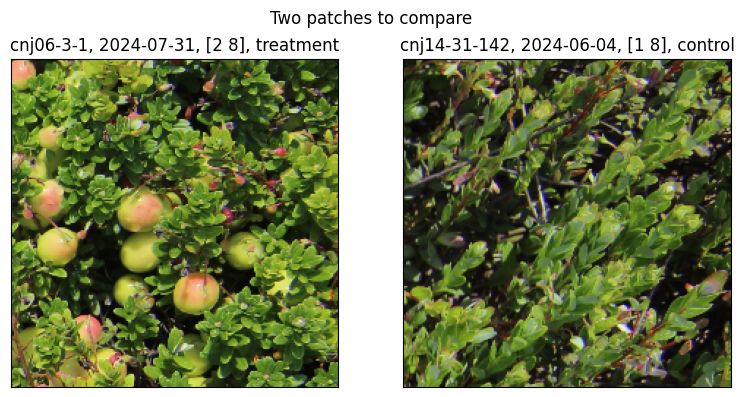

In [124]:
# t0_idx = 100 # no berries
t0_idx = 43 # lots of unripe berries
t1_idx = 160 # lots of ripe berries

# t0_idx = 160
# t1_idx = 43

t0_idx = 43
t1_idx = 100

t0_img = images[t0_idx]
t1_img = images[t1_idx]

fig, axs = plt.subplots(ncols=2, figsize=(8,4))
axs[0].imshow(t0_img.numpy().transpose(1,2,0))
axs[1].imshow(t1_img.numpy().transpose(1,2,0))
axs[0].set_title(', '.join([str(l[t0_idx]) for l in rich_labels.values()]))
axs[1].set_title(', '.join([str(l[t1_idx]) for l in rich_labels.values()]))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Two patches to compare")
plt.tight_layout()
plt.show()

In [125]:
import torch.functional as F
# from pytorch_grad_cam import GradCAM
import pytorch_grad_cam
reload(pytorch_grad_cam)
from pytorch_grad_cam import GradCAM

class HFFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(HFFeatureExtractor, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model({'pixel_values': x})['latent']

wrapped_model = HFFeatureExtractor(model)
wrapped_model.to(torch.device('cpu'))

for param in wrapped_model.parameters():
    param.requires_grad = True

n_registers = 4 if 'registers' in model.backbone_name else 0

In [126]:
t0_input = processor(t0_img, return_tensors='pt')
t1_input = processor(t1_img, return_tensors='pt')

t0_concept_feature = model(t0_input)['latent'][0].detach()
t1_concept_feature = model(t1_input)['latent'][0].detach()
print(t1_concept_feature.shape)

# print(t0_img.max())
# print(processor)

torch.Size([192])


0.9999999
0.0


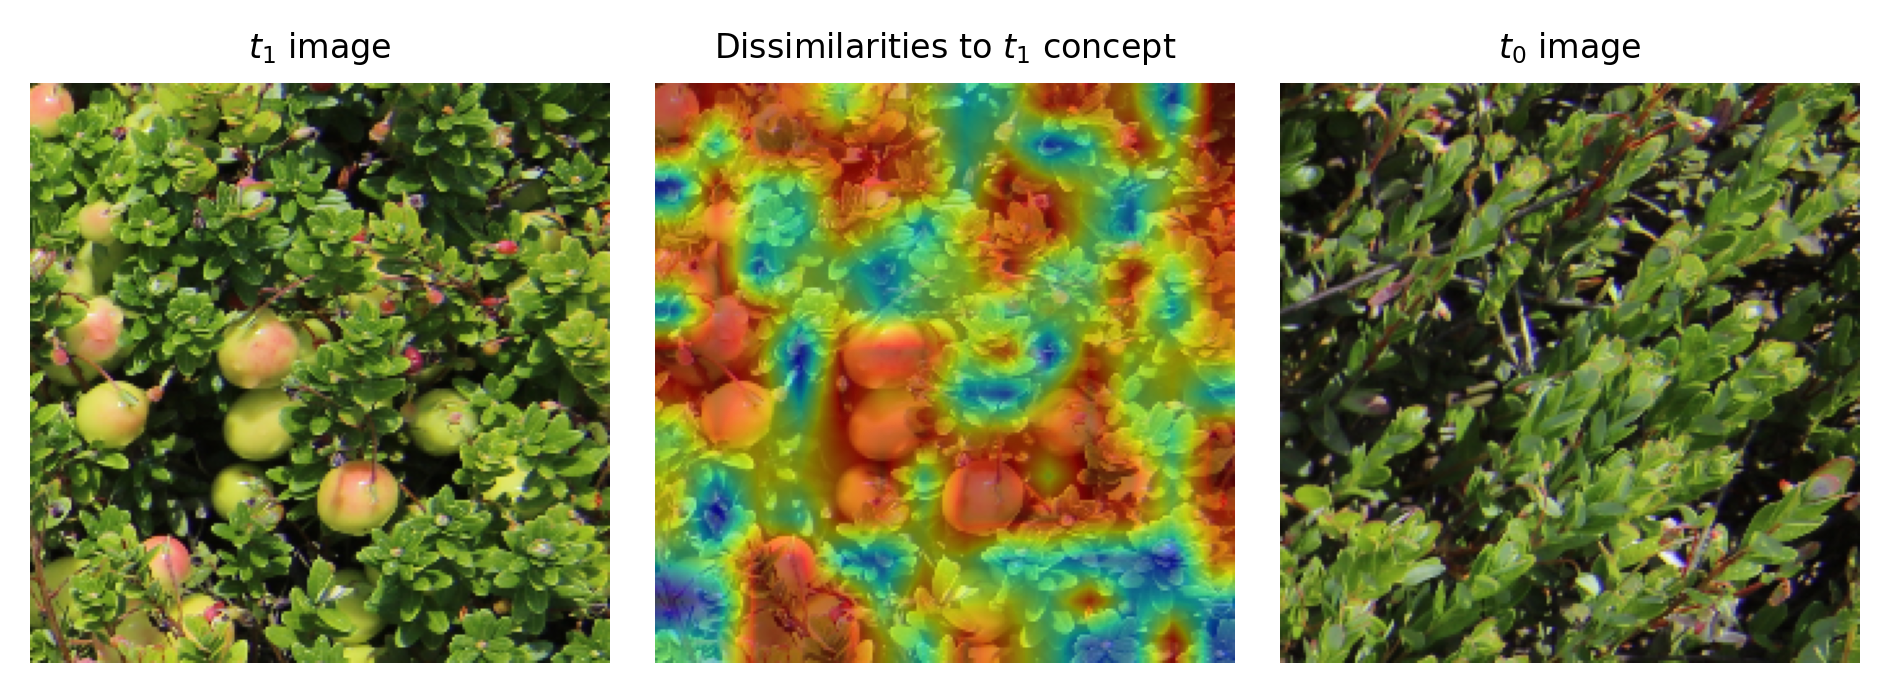

[-0.5, 223.5, 223.5, -0.5]


In [ ]:
class DissimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        loss_fn = torch.nn.CosineSimilarity(dim=0)
        # loss_fn = torch.nn.MSELoss()
        return 1 - loss_fn(model_output, self.features)
    
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        loss_fn = torch.nn.CosineSimilarity(dim=0)
        # loss_fn = torch.nn.MSELoss()
        return loss_fn(model_output, self.features)
    
def reshape_transform(tensor):
    w = int(np.sqrt(tensor.shape[1])) # assume all images are sqare
    result = tensor[:, 1+n_registers:  , :].reshape(tensor.size(0), w, w, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

if 'vit' in model.backbone_name:
    target_layer = wrapped_model.model.backbone.encoder.layer[-1].layernorm_before
else:
    target_layer = wrapped_model.model.backbone.encoder.layer[-1].norm1

# target_layer.requires_grad_()

concept_targets = [
    SimilarityToConceptTarget(t1_concept_feature),
    DissimilarityToConceptTarget(t1_concept_feature)
]

with GradCAM(model=wrapped_model, target_layers=[target_layer], reshape_transform=reshape_transform) as cam:
    cam = cam(
        input_tensor=t0_input['pixel_values'].repeat(len(concept_targets),1, 1, 1),
        targets=concept_targets
    )

plt.close('all')
fig, axs = plt.subplots(nrows=1, ncols=3, dpi=300)
w = cam.shape[1]
t0_img_np = t0_img.numpy().transpose(1,2,0)
t1_img_np = t1_img.numpy().transpose(1,2,0) #TODO check these transposes, i might have broke them


axs[0].imshow(t0_img_np)
axs[0].axis('off')
axs[0].set_title(r'$t_1$ image', fontsize=8)
axs[2].imshow(t1_img_np)
axs[2].axis('off')
axs[2].set_title(r'$t_0$ image', fontsize=8)


axs[1].imshow(cv2.resize(t0_img_np, (w,w)))

# hm = np.clip(0.6-cam[0], 0, 1)
# x = np.linspace(-0.5, 223.5, 224)
# y = np.linspace(-0.5, 223.5, 224)
# X, Y = np.meshgrid(x, y)



# imthing = axs[1].imshow(np.clip(0.6-cam[0], 0, 1), cmap='jet', alpha=0.3)
axs[1].imshow(cam[1], cmap='jet', alpha=0.5)
axs[1].axis('off')

# axs[1].contour(X, Y, hm, levels=2, colors='white', linewidths=1)

# axs[1].set_title(r'Dissimilarities to $t_1$ concept', fontsize=8)
axs[1].set_title(r'Similarities to $t_0$ concept', fontsize=8)

plt.tight_layout()
print(cam[0].max())
print(cam[0].min())

plt.show()
print(imthing.get_extent())

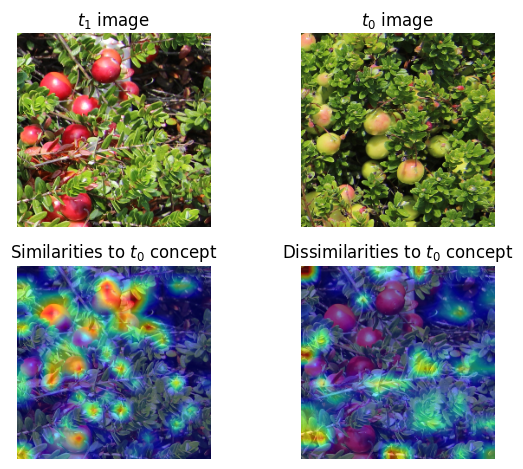

In [84]:
# concept_target = SimilarityToConceptTarget(t0_concept_feature)
concept_targets = [
    SimilarityToConceptTarget(t0_concept_feature),
    DissimilarityToConceptTarget(t0_concept_feature)
]

with GradCAM(model=wrapped_model, target_layers=[target_layer], reshape_transform=reshape_transform) as cam:
    cam = cam(
        input_tensor=t1_input['pixel_values'].repeat(len(concept_targets),1, 1, 1),
        targets=concept_targets
    )

fig, axs = plt.subplots(nrows=2, ncols=2)
w = cam.shape[1]
t0_img_np = t0_img.numpy().transpose(1,2,0)
t1_img_np = t1_img.numpy().transpose(1,2,0)

axs[0,0].imshow(t1_img_np)
axs[0,0].axis('off')
axs[0,0].set_title(r'$t_1$ image')
axs[0,1].imshow(t0_img_np)
axs[0,1].axis('off')
axs[0,1].set_title(r'$t_0$ image')

for i, ax in enumerate(axs[1]):
    ax.imshow(cv2.resize(t1_img_np, (w,w)))
    ax.imshow(cam[i], cmap='jet', alpha=0.5)
    ax.axis('off')

axs[1, 0].set_title(r'Similarities to $t_0$ concept')
axs[1, 1].set_title(r'Dissimilarities to $t_0$ concept')

plt.tight_layout()

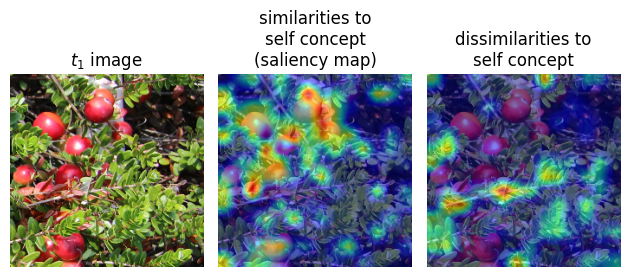

In [85]:
concept_targets = [
    SimilarityToConceptTarget(t1_concept_feature),
    DissimilarityToConceptTarget(t1_concept_feature)
]

with GradCAM(model=wrapped_model, target_layers=[target_layer], reshape_transform=reshape_transform) as cam:
    cam = cam(
        input_tensor=t1_input['pixel_values'].repeat(len(concept_targets),1, 1, 1),
        targets=concept_targets
    )

fig, axs = plt.subplots(ncols=3)
w = cam.shape[1]
t0_img_np = t0_img.numpy().transpose(1,2,0)
t1_img_np = t1_img.numpy().transpose(1,2,0)

axs[0].imshow(t1_img_np)
axs[0].axis('off')
axs[0].set_title(r'$t_1$ image')

axs[1].imshow(cv2.resize(t1_img_np, (w,w)))
axs[1].imshow(cam[0], cmap='jet', alpha=0.5)
axs[1].axis('off')
axs[1].set_title('similarities to\nself concept\n(saliency map)')

axs[2].imshow(cv2.resize(t1_img_np, (w,w)))
axs[2].imshow(cam[1], cmap='jet', alpha=0.5)
axs[2].axis('off')
axs[2].set_title('dissimilarities to\nself concept')

plt.tight_layout()